# Comparison of Mission Arrays with 4.5 m AWAC

In [9]:
import cftime
import glob
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from scipy import stats

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
mission_list = glob.glob('../microSWIFT_data/final_dataset/mission_*.nc')
bathy_file = '../microSWIFT_data/FRFdata/' \
             'FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'

In [22]:
microSWIFT_sig_wave_heights = []
mission_times = []
standard_deviations = []
awac_sig_wave_heights = []
num_waves_in_mission = []
mean_wave_periods  = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs, \
    wave_periods = mission_tools.compute_individual_waves(x_locations,
                                                          y_locations,
                                                          eta, time,
                                                          bathy_file)

    sig_wave_height, \
    standard_dev  = mission_tools.compute_sig_wave_height_top_third(wave_heights)

    microSWIFT_sig_wave_heights.append(sig_wave_height)
    num_waves_in_mission.append(len(wave_heights))
    standard_deviations.append(standard_dev)
    mission_time = np.median(mission_dataset['time'][:])
    mission_times.append(mission_time)
    mean_wave_periods.append(np.mean(wave_periods))

    awac_sig_wave_heights.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Compare the Significant Wave Heights between the microSWIFT arrays and the AWAC

9.477458846706311e-21


(0.0, 4.0)

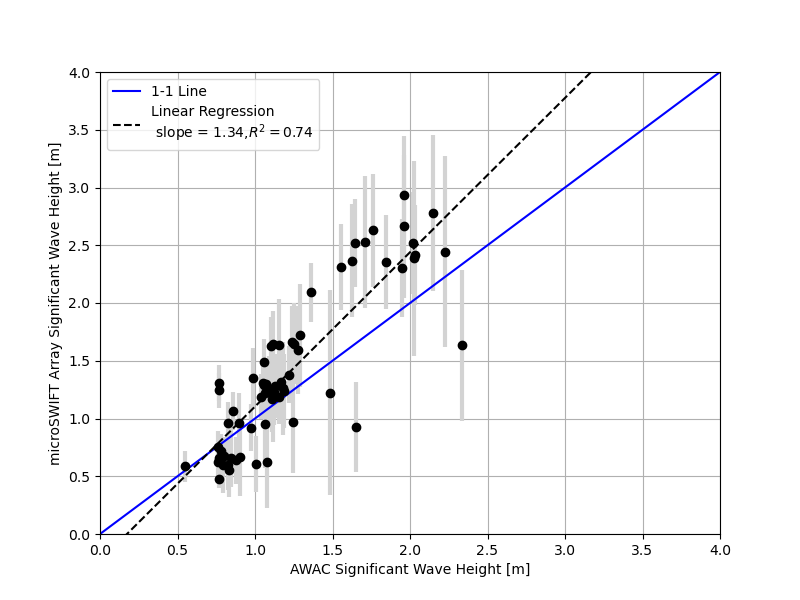

In [12]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope, \
intercept, \
r_value, \
p_value, \
std_err = stats.linregress(microSWIFT_sig_wave_heights,
                           awac_sig_wave_heights)
print(p_value)
x = np.linspace(0, 4.5)
y = slope * x + intercept

fig, ax = plt.subplots(figsize=(8,6))
ax.errorbar(microSWIFT_sig_wave_heights, awac_sig_wave_heights,
            yerr=standard_deviations, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0)
ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x, y, color='k', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax.set_ylabel('microSWIFT Array Significant Wave Height [m]')
ax.set_xlabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4)
ax.set_ylim(0, 4)

## Compute Residuals between the AWAC and microSWIFT significant wave heights

0.1802758605108772


(array([ 2.,  0.,  2.,  1.,  8.,  5.,  6., 13.,  6.,  6.,  7.,  3.,  3.,
         3.,  3.]),
 array([-0.72972458, -0.6165094 , -0.50329422, -0.39007904, -0.27686386,
        -0.16364868, -0.0504335 ,  0.06278168,  0.17599686,  0.28921204,
         0.40242722,  0.5156424 ,  0.62885758,  0.74207276,  0.85528794,
         0.96850312]),
 <BarContainer object of 15 artists>)

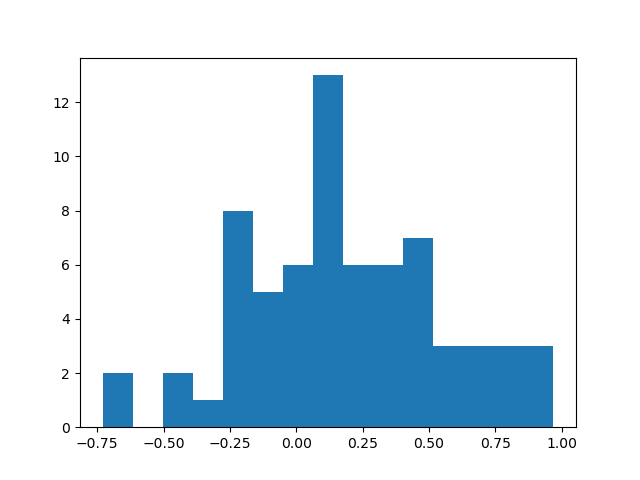

In [31]:
sig_wave_height_residual =  np.array(awac_sig_wave_heights) - np.array(microSWIFT_sig_wave_heights)
mean_residual = np.mean(sig_wave_height_residual)
print(mean_residual)
fig, ax = plt.subplots()
ax.hist(sig_wave_height_residual, bins=15)


## Compare the Significant Wave Heights as a time series

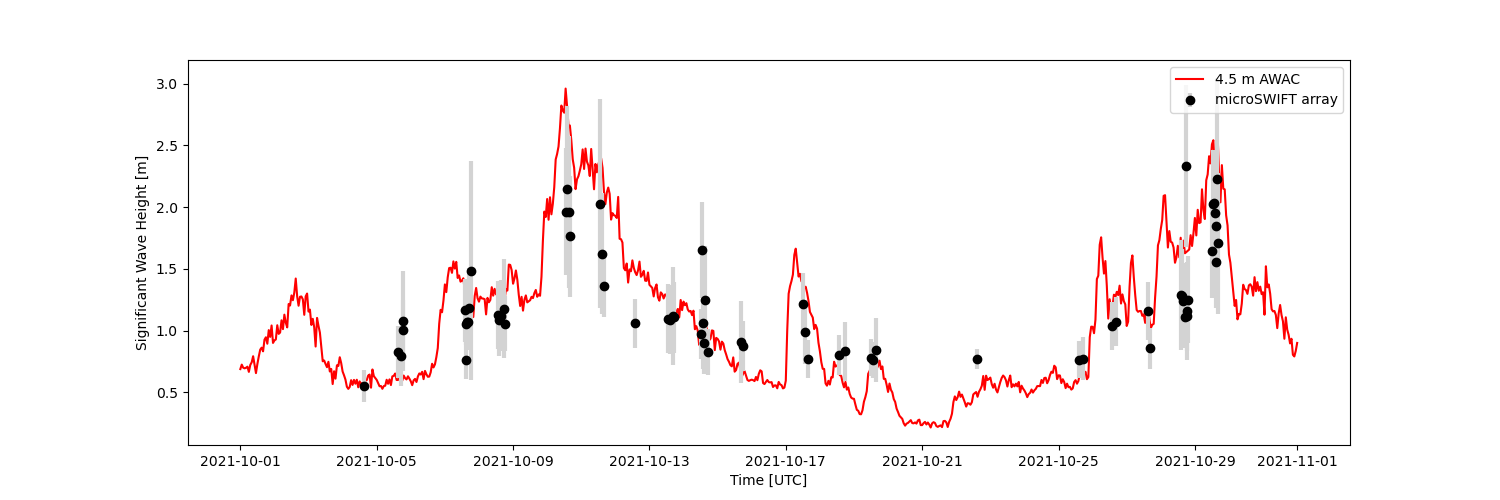

In [13]:
awac_dataset = nc.Dataset(awac_file)
awac_time = cftime.num2pydate(awac_dataset['time'],
                              units=awac_dataset['time'].units,
                              calendar=awac_dataset['time'].calendar)
mission_times_date = cftime.num2pydate(mission_times,
                                       units=mission_dataset['time'].units,
                                       calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:], color='r', label='4.5 m AWAC')
# im = ax.scatter(mission_times_date, microSWIFT_sig_wave_heights,
#            c=num_waves_in_mission, cmap='viridis', label='microSWIFT Arrays')
ax.errorbar(mission_times_date, microSWIFT_sig_wave_heights,
            yerr=standard_deviations, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0, 
            label='microSWIFT array')
ax.set_ylabel('Significant Wave Height [m]')
ax.set_xlabel('Time [UTC]')
ax.legend()
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves')


## Compare only waves between 4-5 meters Bathy to the AWAC

In [33]:
microSWIFT_sig_wave_heights_45 = []
mission_times_45 = []
awac_sig_wave_heights_45 = []
num_waves_in_mission_45 = []
standard_deviations_45 = []

for mission_nc in mission_list:
    mission_dataset = nc.Dataset(mission_nc, mode='r')

    x_locations = mission_dataset['xFRF'][:]
    y_locations = mission_dataset['yFRF'][:]
    eta = mission_dataset['sea_surface_elevation'][:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs, \
    wave_periods = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file)
    
    wave_bathy = mission_tools.compute_wave_bathy(wave_x_locs,
                                                  wave_y_locs,
                                                  bathy_file)
    wave_heights_45 = []
    for n in np.arange(len(wave_bathy)):
        if wave_bathy[n] > -5.3 and wave_bathy[n] < -4.3 and ~np.isnan(wave_heights[n]):
            wave_heights_45.append(wave_heights[n])

    if len(wave_heights_45) > 30:
        significant_wave_height_45, \
        standard_dev_45 = mission_tools.compute_sig_wave_height_top_third(wave_heights_45)
        microSWIFT_sig_wave_heights_45.append(significant_wave_height_45)
        standard_deviations_45.append(standard_dev_45)

        mission_time = np.median(mission_dataset['time'][:])
        mission_times_45.append(mission_time)
        num_waves_in_mission_45.append(len(wave_heights_45))

        awac_sig_wave_heights_45.append(mission_tools.closest_awac_sig_wave_height(mission_time, awac_file))
    else:
        continue

/Users/edwinrainville/opt/miniconda3/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:758: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


## Compare the significant wave heights between 4-5 meters

2.2456483329384137e-09


(0.0, 4.5)

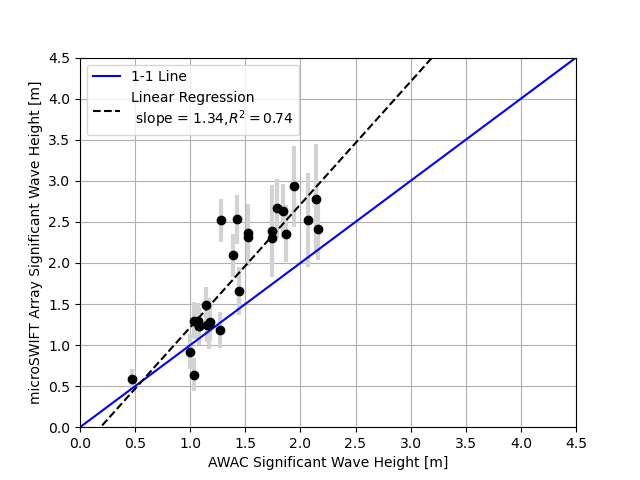

In [34]:
# Compute linear regression between the microSWIFT arrays and the AWAC
slope_45, \
intercept_45, \
r_value_45, \
p_value_45, \
std_err_45 = stats.linregress(microSWIFT_sig_wave_heights_45,
                              awac_sig_wave_heights_45)
print(p_value_45)
x_45 = np.linspace(0, 4.5)
y_45 = slope_45 * x + intercept_45

fig, ax = plt.subplots()
# ax.scatter(microSWIFT_sig_wave_heights_45, awac_sig_wave_heights_45, 
#            c=num_waves_in_mission_45, cmap='viridis')
ax.errorbar(microSWIFT_sig_wave_heights_45, awac_sig_wave_heights_45,
            yerr=standard_deviations_45, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0)

ax.plot([0, 4.5], [0, 4.5], label='1-1 Line', color='b')
ax.plot(x_45, y_45, color='k', linestyle='dashed', 
        label='Linear Regression \n slope = {0:.2f},' \
              '$R^2 = {1:.2f}$'.format(slope, r_value**2))
ax.set_ylabel('microSWIFT Array Significant Wave Height [m]')
ax.set_xlabel('AWAC Significant Wave Height [m]')
ax.grid()
ax.legend()
ax.set_xlim(0, 4.5)
ax.set_ylim(0, 4.5)
# ax.axis('equal')
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves in Distribution')

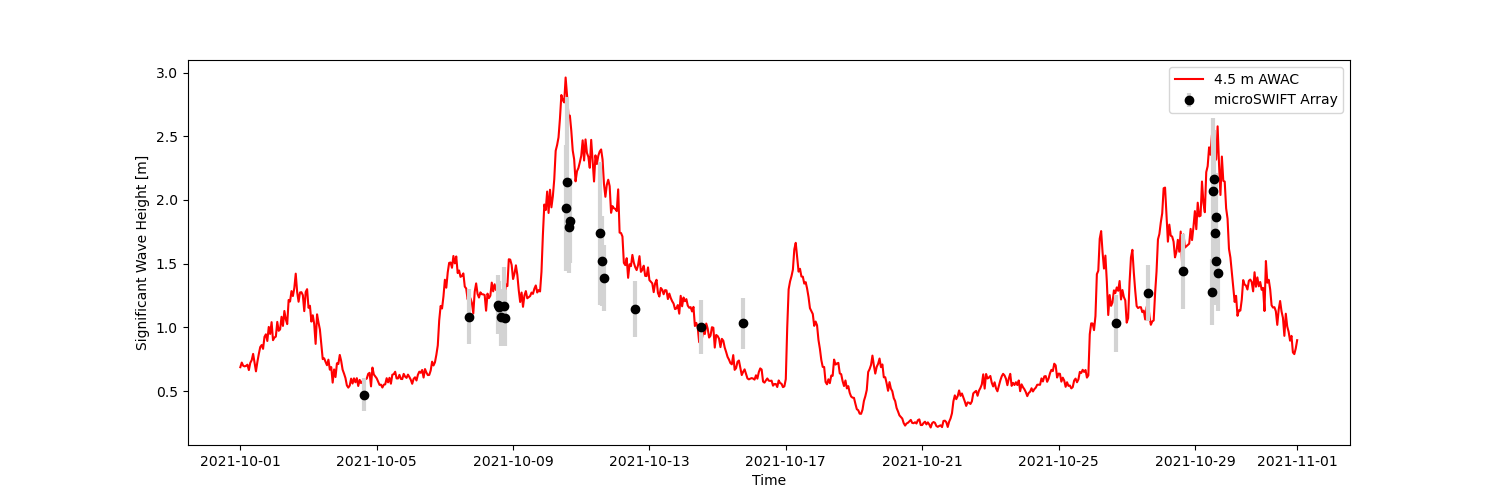

In [35]:
mission_times_date_45 = cftime.num2pydate(mission_times_45,
                                          units=mission_dataset['time'].units,
                                          calendar=mission_dataset['time'].calendar)

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveHs'][:], color='r', label='4.5 m AWAC')
# ax.scatter(mission_times_date_45, microSWIFT_sig_wave_heights_45,
#            c=num_waves_in_mission_45, cmap='viridis', label='microSWIFT Arrays')
ax.errorbar(mission_times_date_45, microSWIFT_sig_wave_heights_45,
            yerr=standard_deviations_45, fmt='o', color='black',
            ecolor='lightgray', elinewidth=3, capsize=0, label='microSWIFT Array')
# ax2 = ax.twinx()
# ax2.plot(awac_time, awac_dataset['waveMeanDirection'][:], color='b')
# ax2.axhline(71.8)
# ax2.set_ylabel('Mean Wave Direction [degrees]', color='b')
ax.set_ylabel('Significant Wave Height [m]')
ax.set_xlabel('Time')
ax.legend()
# cbar = fig.colorbar(im, ax=ax)
# cbar.set_label('Number of Individual Waves')

0.42888661420331536


(array([1., 0., 2., 0., 6., 3., 2., 1., 2., 2., 3., 2., 1., 1., 1.]),
 array([-0.39187324, -0.28289505, -0.17391686, -0.06493867,  0.04403952,
         0.15301771,  0.2619959 ,  0.37097409,  0.47995228,  0.58893047,
         0.69790866,  0.80688685,  0.91586504,  1.02484323,  1.13382142,
         1.24279961]),
 <BarContainer object of 15 artists>)

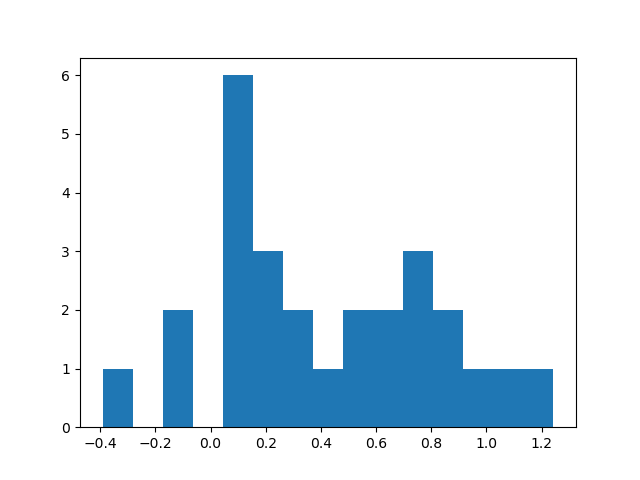

In [36]:
sig_wave_height_residual_45 =  np.array(awac_sig_wave_heights_45) - np.array(microSWIFT_sig_wave_heights_45)
mean_residual_45 = np.mean(sig_wave_height_residual_45)
print(mean_residual_45)
fig, ax = plt.subplots()
ax.hist(sig_wave_height_residual_45, bins=15)

## Compare Mean Wave Periods with AWAC

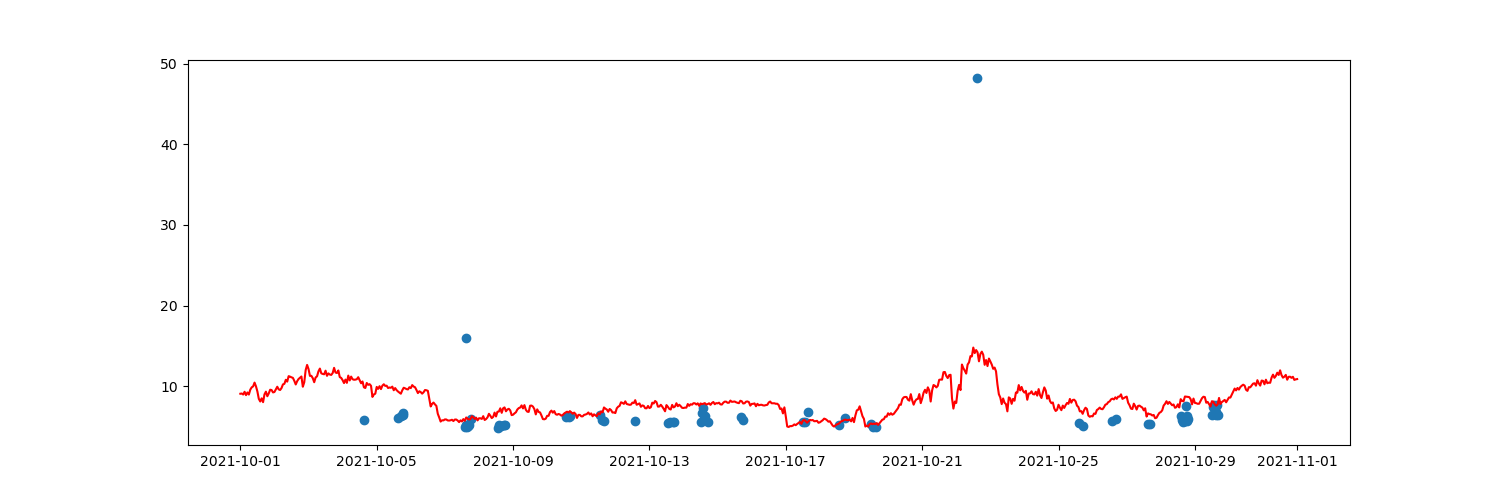

In [24]:
fig, ax = plt.subplots(figsize=(15,5))
ax.plot(awac_time, awac_dataset['waveTm'][:], color='r', label='4.5 m AWAC')
ax.scatter(mission_times_date, mean_wave_periods)

In [25]:
awac_dataset['waveTm']

<class 'netCDF4._netCDF4.Variable'>
float32 waveTm(time)
    _FillValue: -999.99
    units: s
    standard_name: sea_surface_wave_mean_period_from_variance_spectral_density_inverse_frequency_moment
    description: Period for the mean of the energy density spectrum
    long_name: Mean Spectral Period
    coordinates: lat lon
    short_name: Tm
unlimited dimensions: time
current shape = (741,)
filling on